In [128]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, binom, bernoulli

from ab_testing.synthetic_data.simulate_ab_variants import generate_binomial_variants

In [226]:
def binom_log_likelihood_ratio(s, p0, p1):
    """
    likelihood ratio of number of successes in a binomial sample for two parameters
    """
    success = s.sum()
    n = s.shape[0]
    l0 = binom.pmf(k=success, n=n, p=p0)
    l1 = binom.pmf(k=success, n=n, p=p1)
    
    return np.log(l1 / l0)

binom_log_likelihood_ratio(
    s=np.array([1, 0, 1, 0, 1, 1, 1]),
    p0=.5,
    p1=.7,
)

0.660709935574084

In [668]:
binom_log_likelihood_ratio(
    s=np.array([0]),
    p0=.3,
    p1=.6,
)

-0.5596157879354225

In [98]:
def get_thresholds(alpha, beta):
    return np.log(beta / (1 - alpha)), np.log((1 - beta) / alpha)

get_thresholds(.1, .8)

(-0.11778303565638339, 0.6931471805599451)

In [85]:
n1, n2 = 1000, 1000
s1, s2 = generate_binomial_variants(n1=n1, n2=n2, theta1=.5, theta2=.55)

s1, s2

ttest_ind(s1, s2)

Ttest_indResult(statistic=-3.2745239001227446, pvalue=0.0010764851760551217)

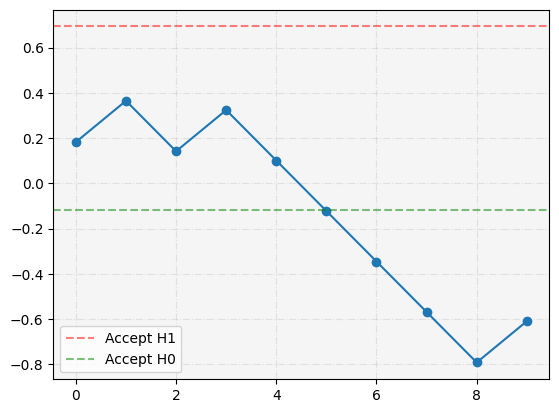

{'decision': 'Accept H0',
 'a': -0.11778303565638339,
 'b': 0.6931471805599451,
 'sum_lr': array([ 0.18232156,  0.36464311,  0.14149956,  0.32382112,  0.10067757,
        -0.12246598, -0.34560953, -0.56875309, -0.79189664, -0.60957508]),
 'first_hit_a': 5,
 'first_hit_b': None}

In [818]:
def simple_wald_sprt(s, p0, p1, alpha, beta, plot=False):
    a, b = get_thresholds(alpha, beta)
    sum_llr = 0
    sum_llr_results = []
    for i, sample in enumerate(s):
        sum_llr += binom_log_likelihood_ratio(s[i:i + 1], p0, p1)
        sum_llr_results.append(sum_llr)
    
    sum_llr_results = np.array(sum_llr_results)
    
    mask_a = (sum_llr_results <= a)
    hit_a = None
    if any(mask_a):
        hit_a = np.nonzero(mask_a)[0][0]
    
    mask_b = (sum_llr_results >= b)
    hit_b = None
    if any(mask_b):
        hit_b = np.nonzero(mask_b)[0][0]

    decision = "Unconclusive"
    if not hit_a and not hit_b:
        pass
    elif hit_a and hit_b:
        if hit_a < hit_b:
            decision = "Accept H0"
        else:
            decision = "Accept H1"
    elif hit_a:
        decision = "Accept H0"
    else:
        decision = "Accept H1"

    results = {"decision": decision, "a": a, "b": b, "sum_lr": sum_llr_results, "first_hit_a": hit_a, "first_hit_b": hit_b}
        
    
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(results["sum_lr"], marker="o")
        ax.axhline(results["b"], color="red", alpha=.5, linestyle="--", label="Accept H1")
        ax.axhline(results["a"], color="green", alpha=.5, linestyle="--", label="Accept H0")
        ax.set_facecolor("whitesmoke")
        ax.grid(True, linestyle="-.", alpha=.3)
        ax.legend()
        plt.show()
    
    return results

results = simple_wald_sprt(
    bernoulli.rvs(size=10, p=.6),
    p0=.5,
    p1=.6,
    alpha=0.1,
    beta=0.8,
    plot=True
)

results